In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("datasets/train.csv")

In [3]:
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [4]:
df.shape

(913000, 4)

In [5]:
df.date.min()

'2013-01-01'

In [6]:
df.date.max()

'2017-12-31'

In [7]:
df_sales = df.copy()
#convert date field from string to datetime
df_sales['date'] = pd.to_datetime(df_sales['date'])
#represent month in date field as its first day
df_sales['date'] = df_sales['date'].dt.year.astype('str') + '-' + df_sales['date'].dt.month.astype('str') + '-01'
df_sales['date'] = pd.to_datetime(df_sales['date'])
#groupby date and sum the sales
df_sales = df_sales.groupby('date').sales.sum().reset_index()

In [8]:
#create a new dataframe to model the difference
df_diff = df_sales.copy()
#add previous sales to the next row
df_diff['prev_sales'] = df_diff['sales'].shift(1)
#drop the null values and calculate the difference
df_diff = df_diff.dropna()
df_diff['diff'] = (df_diff['sales'] - df_diff['prev_sales'])
df_diff.head()

,date,sales,prev_sales,diff
1,2013-02-01,459417,454904.0,4513.0
2,2013-03-01,617382,459417.0,157965.0
3,2013-04-01,682274,617382.0,64892.0
4,2013-05-01,763242,682274.0,80968.0
5,2013-06-01,795597,763242.0,32355.0


In [9]:
#create dataframe for transformation from time series to supervised
df_supervised = df_diff.drop(['prev_sales'],axis=1)
#adding lags
for inc in range(1,13):
    field_name = 'lag_' + str(inc)
    df_supervised[field_name] = df_supervised['diff'].shift(inc)
#drop null values
df_supervised = df_supervised.dropna().reset_index(drop=True)

In [10]:
# Import statsmodels.formula.api
import statsmodels.formula.api as smf
# Define the regression formula
model = smf.ols(formula='diff ~ lag_1', data=df_supervised)
# Fit the regression
model_fit = model.fit()
# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)
# 0.02893426930900389

# Define the regression formula
model = smf.ols(formula='diff ~ lag_1+ lag_2 + lag_3 + lag_4 + lag_5 + lag_6 + lag_7+ lag_8 +lag_9 \
                +lag_10+lag_11+lag_12', data=df_supervised)
# Fit the regression
model_fit = model.fit()
# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)
# 0.9795722233296558

0.02893426930900367
0.9795722233296558


In [11]:
#import MinMaxScaler and create a new dataframe for LSTM model
from sklearn.preprocessing import MinMaxScaler
df_model = df_supervised.drop(['sales','date'],axis=1)
#split train and test set
# train: 2014-02-01 ~ 2017-06-01, test_set: 2017-07-01 ~ 2017-12-01
train_set, test_set = df_model[0:-6].values, df_model[-6:].values
#apply Min Max Scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_set)
train_set_scaled = scaler.transform(train_set)
test_set_scaled = scaler.transform(test_set)

In [12]:
X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, TimeDistributed

# single LSTM model
model = Sequential()
model.add(
    LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True)
)
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")
history = model.fit(
    X_train, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False
)
# BiLSTM model
model = Sequential()
model.add(
    Bidirectional(
        LSTM(4, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])
    )
)
model.add(TimeDistributed(Dense(1)))
model.compile(loss="mean_squared_error", optimizer="adam")
history_TD_bilstm = model.fit(X_train, y_train, epochs=100, verbose=1, shuffle=False)

Epoch 1/100
41/41 [==============================] - 1s 932us/step - loss: 0.2277
Epoch 2/100
41/41 [==============================] - 0s 1ms/step - loss: 0.1966
Epoch 3/100
41/41 [==============================] - 0s 667us/step - loss: 0.1735
Epoch 4/100
41/41 [==============================] - 0s 628us/step - loss: 0.1536
Epoch 5/100
41/41 [==============================] - 0s 914us/step - loss: 0.1365
Epoch 6/100
41/41 [==============================] - 0s 811us/step - loss: 0.1219
Epoch 7/100
41/41 [==============================] - 0s 611us/step - loss: 0.1092
Epoch 8/100
41/41 [==============================] - 0s 630us/step - loss: 0.0981
Epoch 9/100
41/41 [==============================] - 0s 654us/step - loss: 0.0882
Epoch 10/100
41/41 [==============================] - 0s 604us/step - loss: 0.0791
Epoch 11/100
41/41 [==============================] - 0s 644us/step - loss: 0.0709
Epoch 12/100
41/41 [==============================] - 0s 634us/step - loss: 0.0634
Epoch 13/100
41

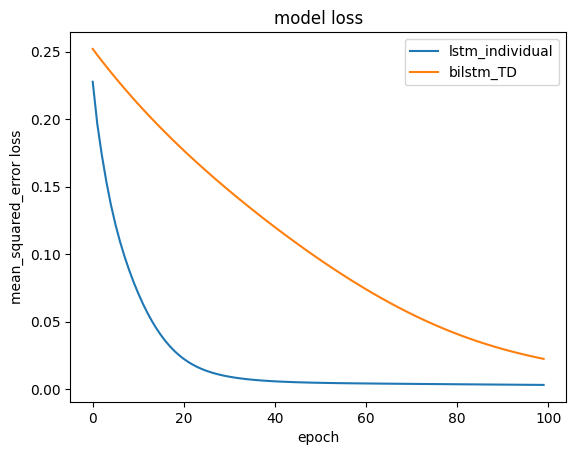

In [24]:
# summarize history for accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
# plt.plot(history_batch.history['loss'])
plt.plot(history_TD_bilstm.history['loss'])
plt.title('model loss')
plt.ylabel('mean_squared_error loss')
plt.xlabel('epoch')
plt.legend(['lstm_individual', 'bilstm_TD'], loc='upper right')
plt.show()

In [18]:
import numpy as np

y_pred = model.predict(X_test,batch_size=1)
#reshape y_pred
y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])
#rebuild test set for inverse transform
pred_test_set = []
for index in range(0,len(y_pred)):
#     print np.concatenate([y_pred[index],X_test[index]],axis=1)
    pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))
#reshape pred_test_set
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
#inverse transform
pred_test_set_inverted = scaler.inverse_transform(pred_test_set)

6/6 [==============================] - 0s 741us/step


In [21]:
result_list = []
sales_dates = list(df_supervised[-7:].date)
act_sales = list(df_supervised[-7:].sales)
for index in range(0,len(pred_test_set_inverted)):
    result_dict = {}
    result_dict['pred_value'] = int(pred_test_set_inverted[index][0] + act_sales[index])
    result_dict['date'] = sales_dates[index+1]
    result_list.append(result_dict)
df_result = pd.DataFrame(result_list)
df_result.head()

,pred_value,date
0,1163605,2017-07-01
1,1085404,2017-08-01
2,945727,2017-09-01
3,867983,2017-10-01
4,899515,2017-11-01


In [23]:
# #merge with actual sales dataframe
# df_sales_pred = pd.merge(df_supervised,df_result,on='date',how='left')
# #plot actual and predicted
# plot_data = [
#     go.Scatter(
#         x=df_sales_pred['date'],
#         y=df_sales_pred['sales'],
#         name='actual'
#     ),
#         go.Scatter(
#         x=df_sales_pred['date'],
#         y=df_sales_pred['pred_value'],
#         name='predicted'
#     )
    
# ]
# plot_layout = go.Layout(
#         title='Sales Prediction'
#     )
# fig = go.Figure(data=plot_data, layout=plot_layout)
# pyoff.iplot(fig)